In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import glob
import os
from PIL import Image
import pickle
from tensorflow.python.keras.applications.xception import Xception, preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image
%matplotlib inline

In [2]:
plt.rcParams['axes.titlesize'] = 18

# Waves - model probabilities

In [3]:
test_images = glob.glob('data/IR/test/*/*.jpg')
len_test = len(test_images)
print(f"Number of images : {len_test}\nsample file_name : {test_images[0]}")

Number of images : 3000
sample file_name : data/IR/test/plunge/147861587516.jpg


In [4]:
def wave_sort(path, I1, wave=[]):
    wave.append(I1)
    for i in range(1, 100):
        I2 = I1 + i
        if os.path.isfile(path+str(I2)+'.jpg'):
            wave = wave_sort(path, I2, wave)
            return wave
    return wave


In [5]:
def get_waves(file_path):
    waves = []
    files = sorted(glob.glob(file_path+'/*.jpg'))
    names = list(map(lambda x: int(x.split('/')[-1][:-4]), files))
    for i in names:
        try:
            if i not in waves[-1]:
                waves.append( wave_sort(file_path+'/', i, []) )
        except:
            waves.append( wave_sort(file_path+'/', i, []) )
            
    return waves

In [6]:
def plot_wave(path, wave):
    for i in wave:
        img = Image.open(path + '/' + str(i) + '.jpg')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.pause(0.1)

In [7]:
plunge_waves = get_waves('data/IR/test/plunge')
spill_waves = get_waves('data/IR/test/spill')
non_waves = get_waves('data/IR/test/nonbreaking')

In [8]:
print(f"number of waves in test: \nplunge : {len(plunge_waves)}" + \
                      f"\nspill : {len(spill_waves)} " + \
                      f"\nnonbreaking : {len(non_waves)}")

number of waves in test: 
plunge : 3
spill : 23 
nonbreaking : 20


In [9]:
# Load the best models

base_model = Xception(weights='imagenet')
try:
    CNNmodel = Model(base_model.input, base_model.get_layer('avg_pool').output)	  
except:
    CNNmodel = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
image_size = (299, 299)

with open('out/xception/IRclassifier.pickle', 'rb') as f:
    irmodel = pickle.load(f)
    
with open('out/xception/Floclassifier.pickle', 'rb') as f:
    flomodel = pickle.load(f)
    
with open('out/xception/conf_classifier.pickle', 'rb') as f:
    IRflomodel = pickle.load(f)
    
with open('out/xception/IR2flo_late_classifier.pickle', 'rb') as f:
    latemodel = pickle.load(f)

/home/ryan/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# brier score
def brier_mult(true, preds):
    return np.mean(np.sum((true-preds)**2, -1))

In [11]:

def inform(true, preds):
    tp = np.zeros(3)
    tn = np.zeros(3)
    fp = np.zeros(3)
    fn = np.zeros(3)
    
    for lab, pred in zip(true, preds):
        if lab == pred:
            tp[lab] += 1
            for i in range(len(tn)):
                if i != lab:
                    tn[i] += 1
        if lab != pred:
            fp[pred] += 1
            fn[lab] += 1
            for i in range(len(tn)):
                if i != pred or lab:
                    tn[i] += 1

    return (tp/(tp+fn)+tn/(tn+fp) -1)

def load_h5_test(feat_path, label_path):
    features = h5py.File(feat_path, 'r')
    labels = h5py.File(label_path, 'r')
    return features, labels

def make_preds(features, model):
    pred = model.predict_proba(features)
    return pred

In [12]:
test_IR = h5py.File('out/xception/IRtestfeatures.h5', 'r')
test_IR = test_IR['dataset_1']
test_IRlab = h5py.File('out/xception/IRtestlabels.h5', 'r')
test_IRlab = test_IRlab['dataset_1']

test_flo = h5py.File('out/xception/Flotestfeatures.h5', 'r')
test_flo = test_flo['dataset_1']
test_flolab = h5py.File('out/xception/Flotestlabels.h5', 'r')
test_flolab = test_flolab['dataset_1']

test_IR2 = h5py.File('out/xception/IR2testfeatures.h5', 'r')
test_IR2 = test_IR2['dataset_1']
test_IR2 = h5py.File('out/xception/IR2testlabels.h5', 'r')
test_IR2 = test_IR2['dataset_1']

test_IRflo = h5py.File('out/xception/conf_testfeatures.h5', 'r')
test_IRflo = test_IRflo['dataset_1']
test_IRflolab = h5py.File('out/xception/conf_testlabels.h5', 'r')
test_IRflolab = test_IRflolab['dataset_1']

test_IRflo_late = h5py.File('out/xception/IR2flo_late_testfeatures.h5', 'r')
test_IRflo_late = test_IRflo_late['dataset_1']
test_IRflolab_late = h5py.File('out/xception/IR2flo_late_testlabels.h5', 'r')
test_IRflolab_late = test_IRflolab_late['dataset_1']

In [13]:
IRpreds = make_preds(test_IR, irmodel)
irinform = inform(test_IRlab[:], np.argmax(IRpreds, -1))
print(irinform, np.mean(irinform))

flopreds = make_preds(test_flo, flomodel)
floinform = inform(test_flolab[:], np.argmax(flopreds, -1))
print(floinform, np.mean(floinform))

IRflopreds = make_preds(test_IRflo, IRflomodel)
IRfloinform = inform(test_IRflolab[:], np.argmax(IRflopreds, -1))
print(IRfloinform, np.mean(IRfloinform))

latepreds = make_preds(test_IRflo_late, latemodel)
lateinform = inform(test_IRflolab_late[:], np.argmax(latepreds, -1))
print(lateinform, np.mean(lateinform))


[0.86914383 0.38510427 0.79014728] 0.6814651239499511
[0.89520752 0.62493455 0.77610573] 0.7654159336986858
[0.90450536 0.47835365 0.85737921] 0.7467460723713275
[0.92901144 0.45302096 0.8875464 ] 0.7565262670391396


In [14]:
def one_hot(labels):
    onehot = np.zeros((len(labels), 3))
    for i, label in enumerate(labels):
        onehot[i, label] = 1
    return onehot

In [15]:
print(brier_mult(one_hot(test_IRlab), IRpreds))
print(brier_mult(one_hot(test_flolab), flopreds))
print(brier_mult(one_hot(test_IRflolab), IRflopreds))
print(brier_mult(one_hot(test_IRflolab_late), latepreds))

0.1325756189324206
0.11814223186386473
0.08749866748539153
0.07297281136713751


In [33]:
def get_wave_probs(cla, wave, indx):
    ir_prob = []
    flo_prob = []
    ir_brier = []
    flo_brier = []
    lateprob = []
    late_brier = []
    one_hot = np.zeros(3)
    one_hot[indx] = 1
    for i in wave:
        try:
            #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
            IRimg = image.load_img(f'data/IR/test/{cla}/{i}.jpg', target_size = image_size)
            IRimg = np.array(IRimg)
            
            #ax1.imshow(IRimg, cmap='gray')
            #ax1.set_title(f'{cla}')
            #ax1.axis('off')

            IRimg = preprocess_input(IRimg)[None]
            IRfeatures = CNNmodel.predict(IRimg)
            IRpred = irmodel.predict_proba(IRfeatures)[0]
            ir_prob.append(IRpred)
            ir_brier.append(brier_mult(one_hot, IRpred))
            
            #ax2.bar(range(3), IRpred)
            #ax2.set_title('IR model')
            #ax2.set_ylim(0, 1)
            #ax2.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])

            floimg = image.load_img(f'data/flow/test/{cla}/{i}.png', target_size = image_size)
            floimg = np.array(floimg)
            floimg = preprocess_input(floimg)[None]
            Flofeatures = CNNmodel.predict(floimg)
            flopred = flomodel.predict_proba(Flofeatures)[0]
            flo_prob.append(flopred)
            flo_brier.append(brier_mult(one_hot, flopred))
            
            #ax3.bar(range(3), flopred)
            #ax3.set_title('Optical flow model')
            #ax3.set_ylim(0, 1)
            #ax3.set_xticklabels([ '', 'nonbreaking', 'plunge', 'spill',])
            
            Latefeatures = np.concatenate((IRfeatures, Flofeatures), 1)
            latepred = latemodel.predict_proba(Latefeatures)[0]
            lateprob.append(latepred)
            late_brier.append(brier_mult(one_hot, latepred))
            
            #ax4.bar(range(3), latepred)
            #ax4.set_title('IR and OF model')
            #ax4.set_ylim(0, 1)
            #ax4.set_xticklabels(['', 'nonbreaking', 'plunge', 'spill'])
            
            #fig.savefig(f'notebook_out/{cla}_{indx}_{i}')
            
        except:
            pass

    return ir_prob, flo_prob, lateprob, ir_brier, flo_brier, late_brier

In [17]:
def plot_wave_probs(wave_prob, brier, title):
    labels = ['nonbreaking', 'plunge', 'spill']
    prob = np.array(wave_prob)
    for i, l in enumerate(labels):
        plt.plot(prob[:, i], label=l)
    plt.plot(brier, 'k--', label=f'Brier score:{np.mean(brier):.2f}')
    plt.xlabel('Image in sequence')
    plt.ylabel('Probability')
    plt.title(title)
    plt.legend()
    plt.savefig(f'notebook_out/{title}')
    plt.show()

In [18]:
for i, j in enumerate(non_waves):
    print(i, len(j))

0 113
1 86
2 46
3 45
4 34
5 18
6 5
7 226
8 37
9 31
10 63
11 43
12 98
13 298
14 115
15 254
16 208
17 207
18 90
19 243


In [ ]:
IRnon, Flonon, Latenon, IRnon_brier, Flonon_brier, Latenon_brier = get_wave_probs('nonbreaking',
                                                                      non_waves[17], 0)

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

In [ ]:
plot_wave_probs(IRnon, IRnon_brier, 'IR - nonbreaking')
plot_wave_probs(Flonon, Flonon_brier, 'Optical flow - nonbreaking')
plot_wave_probs(Latenon, Latenon_brier, 'IR and Optical flow - nonbreaking')

In [23]:
plungecat = []
for i in plunge_waves:
    plungecat = plungecat + i

/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/ryan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too 

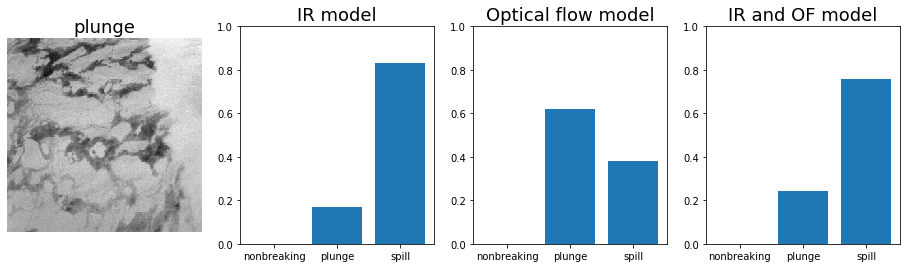

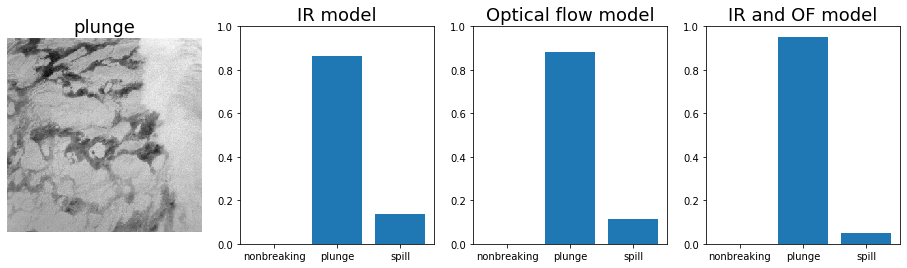

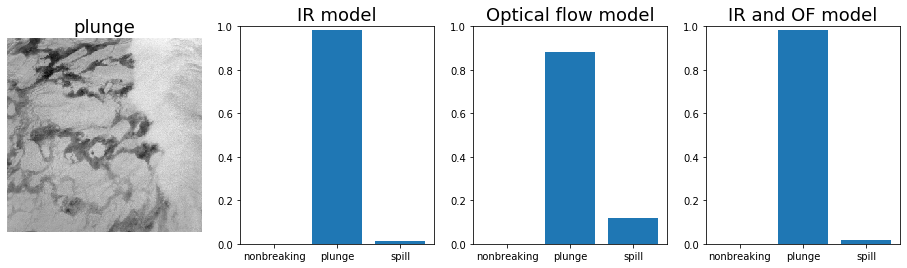

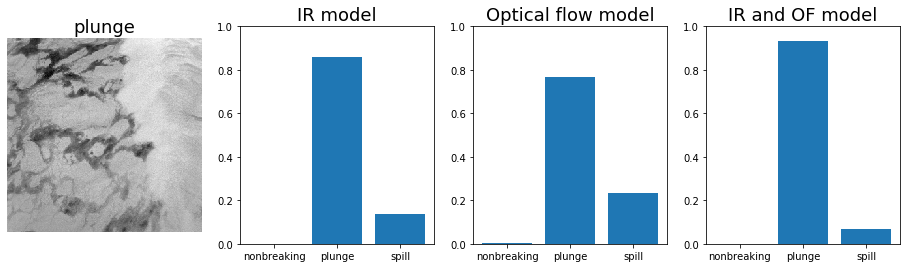

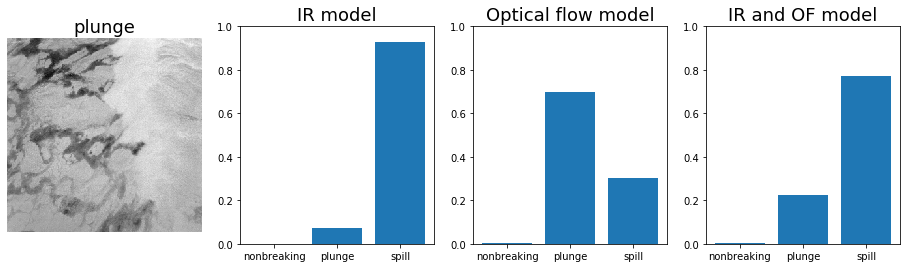

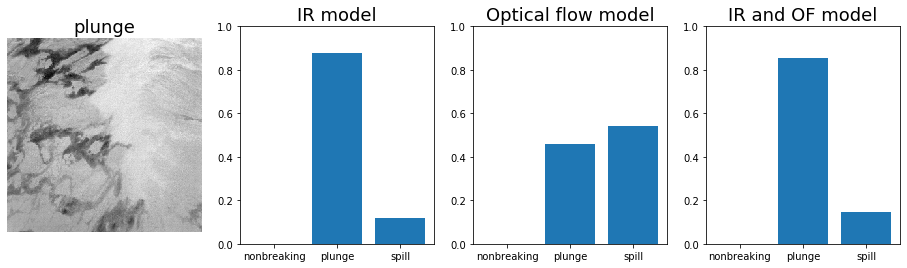

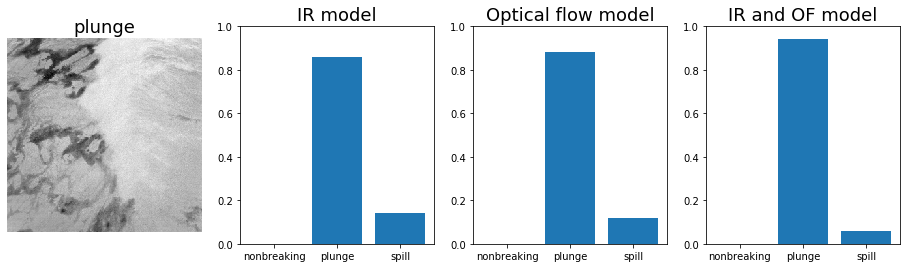

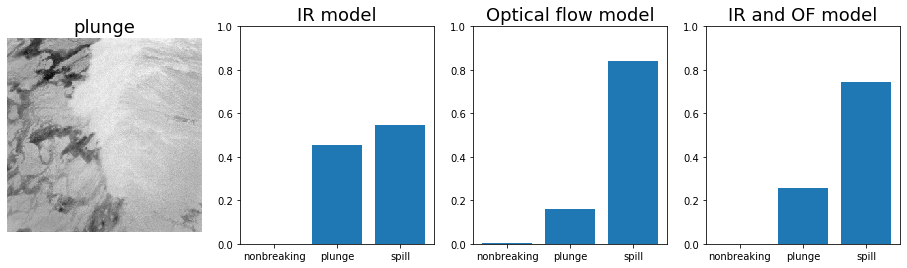

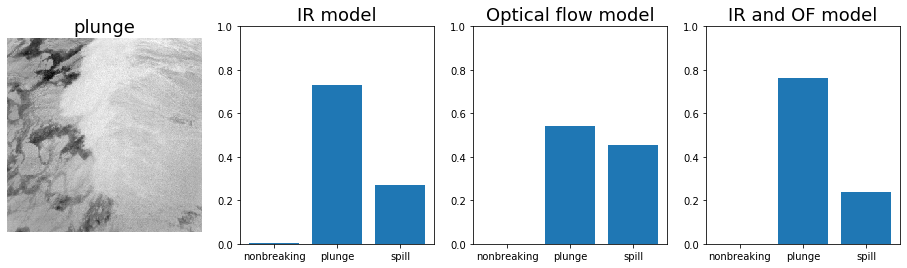

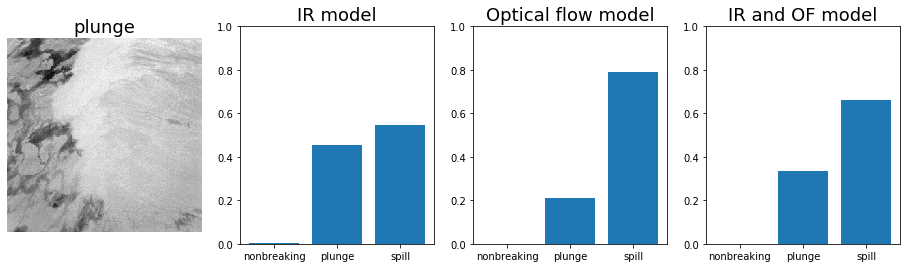

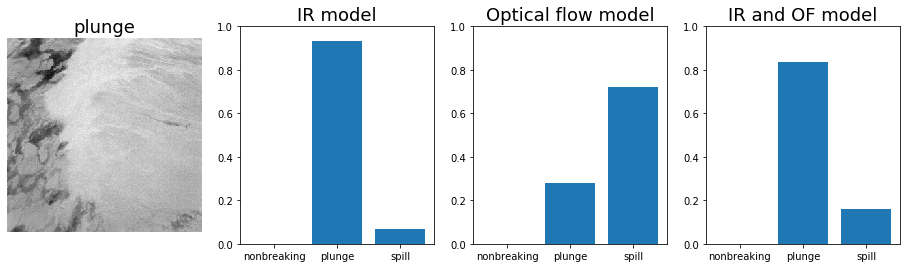

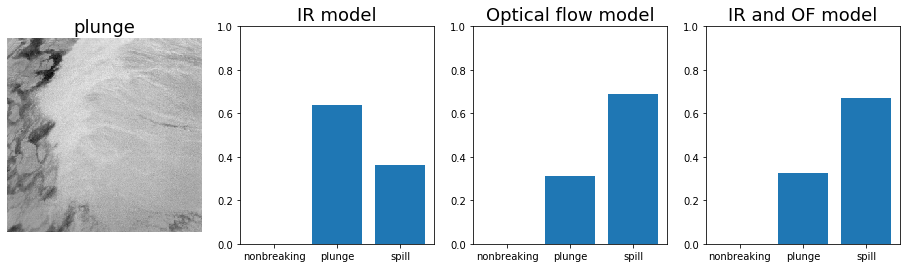

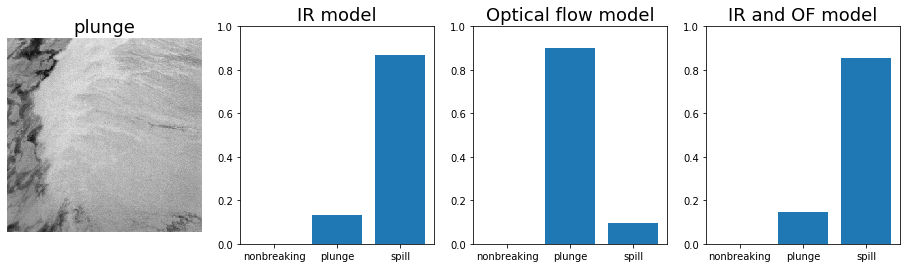

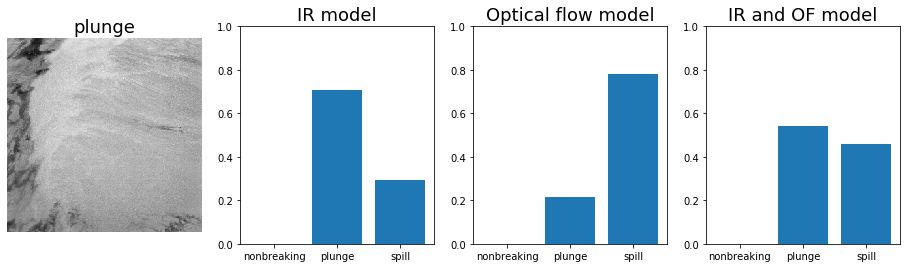

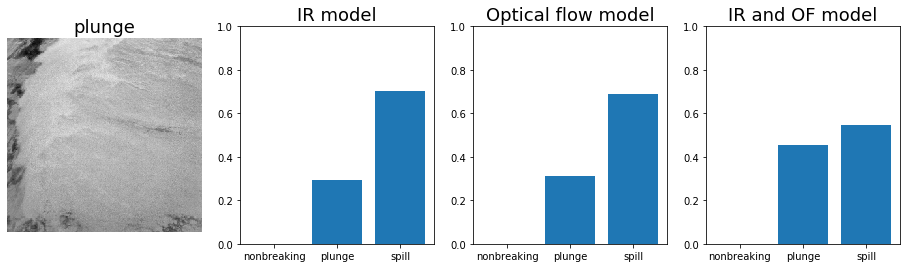

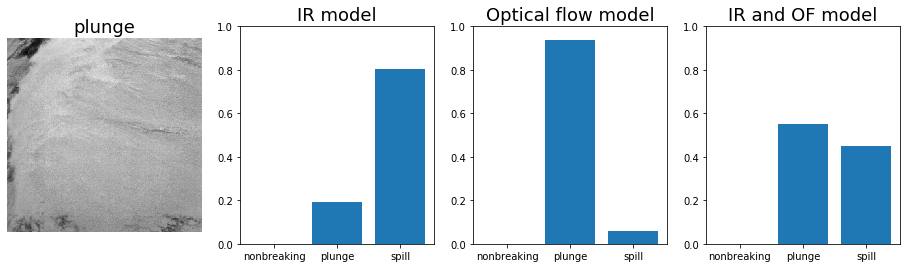

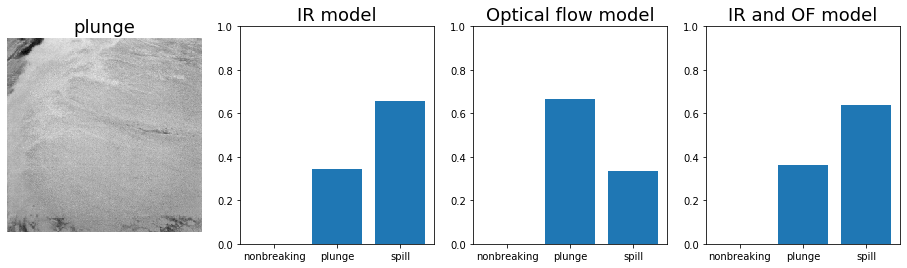

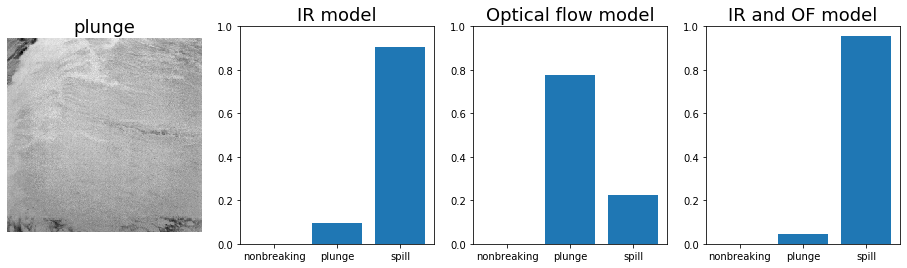

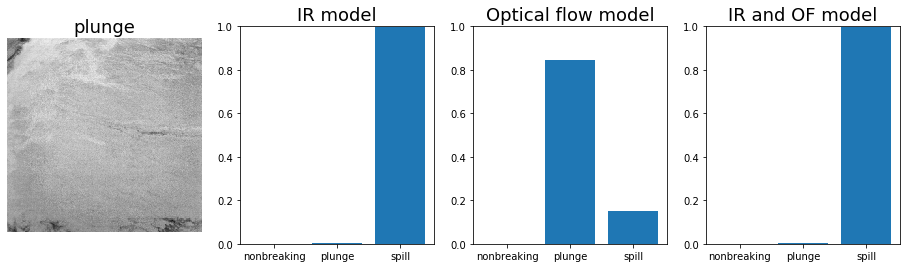

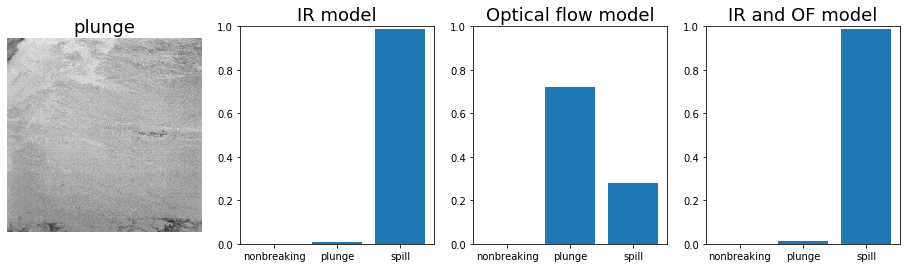

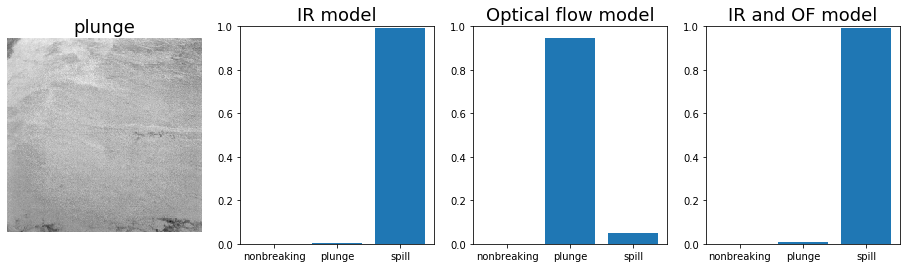

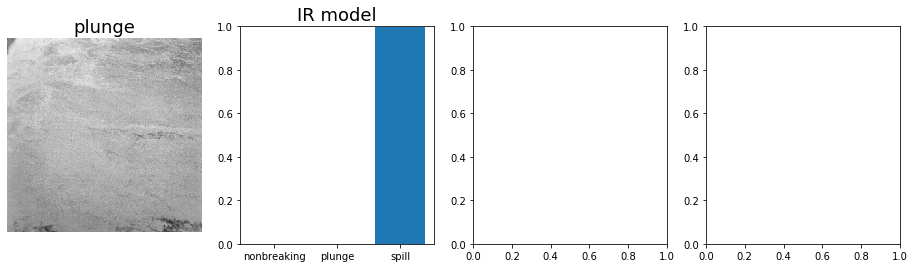

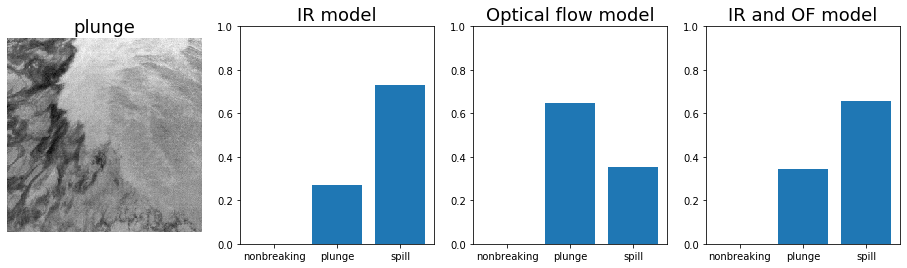

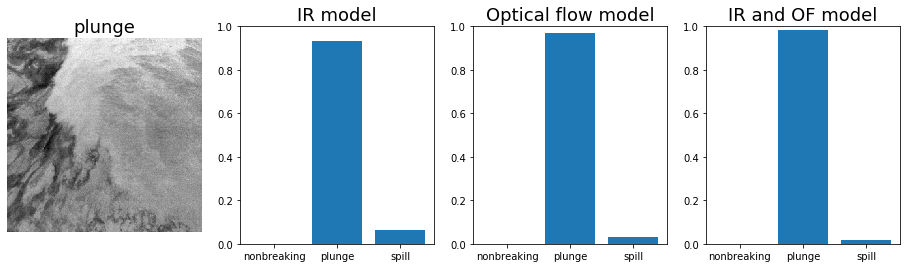

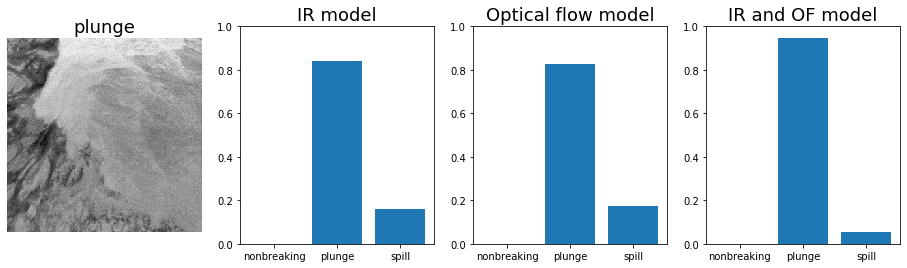

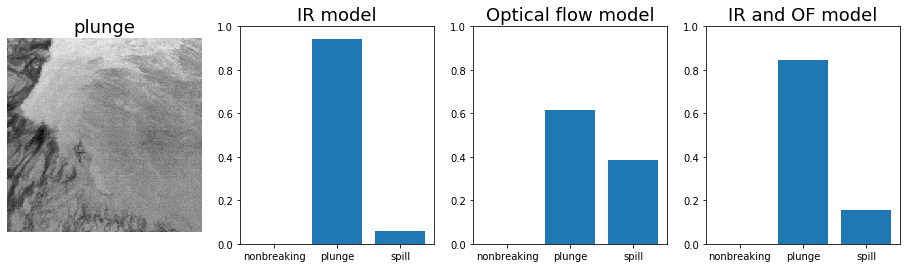

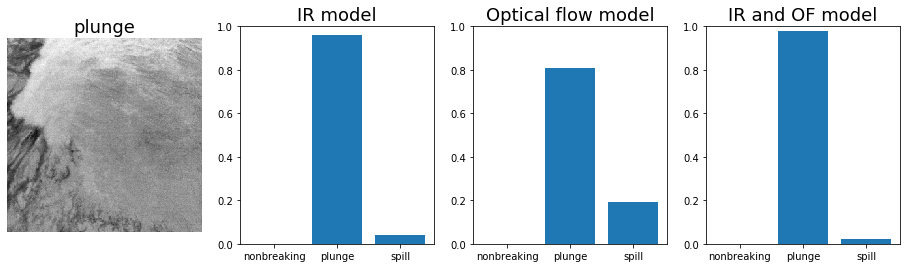

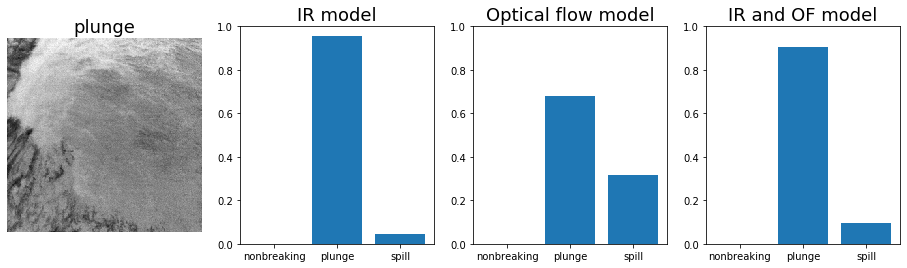

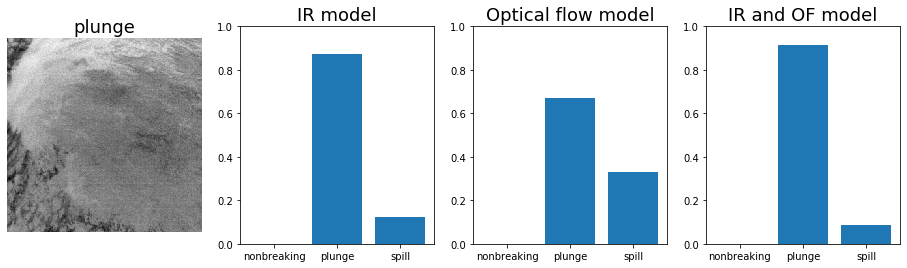

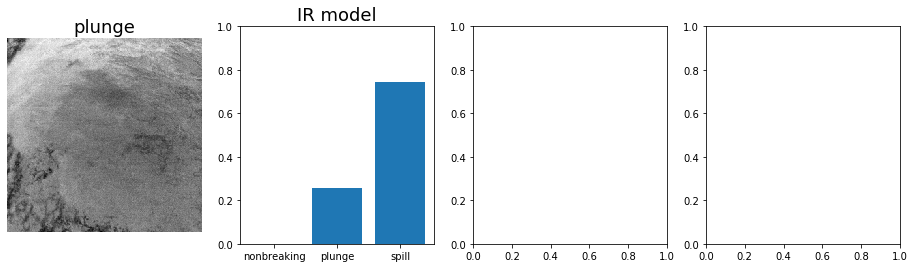

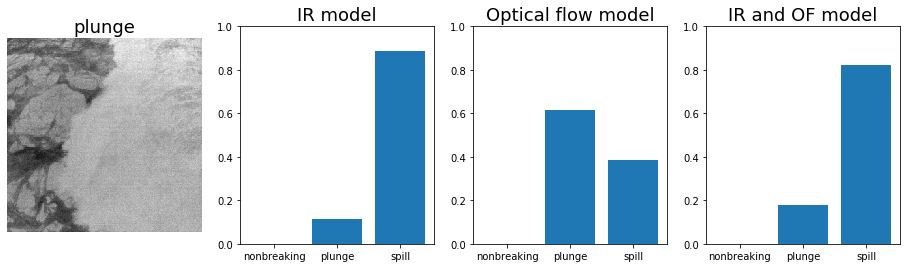

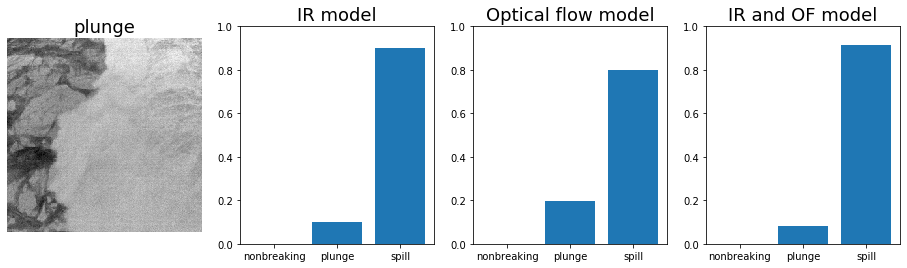

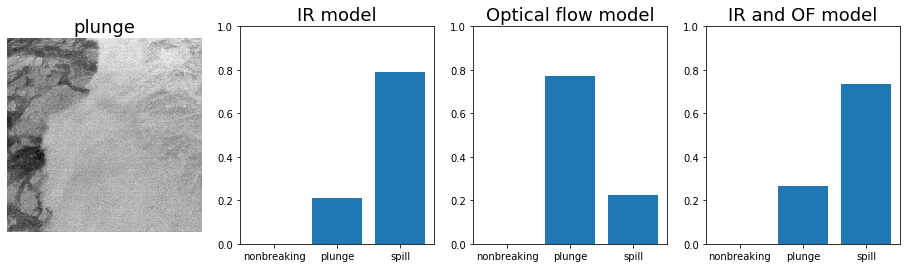

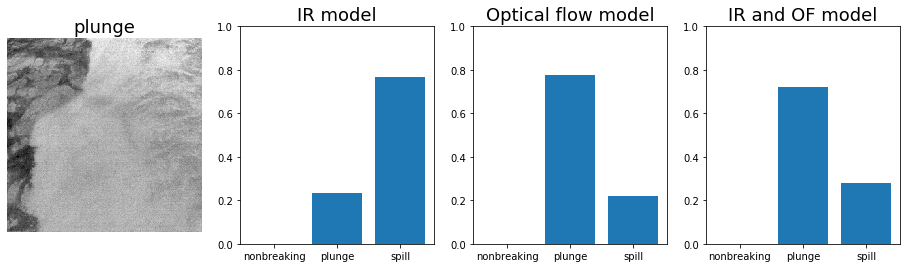

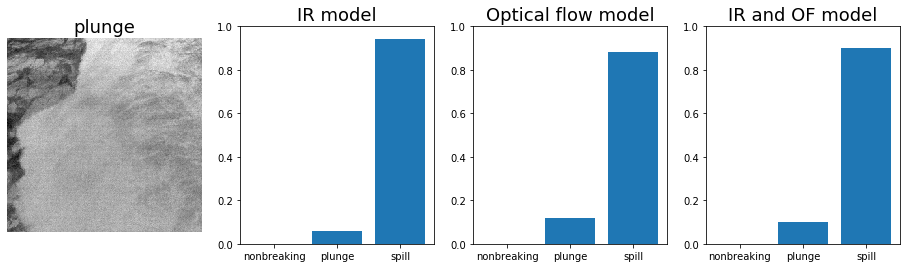

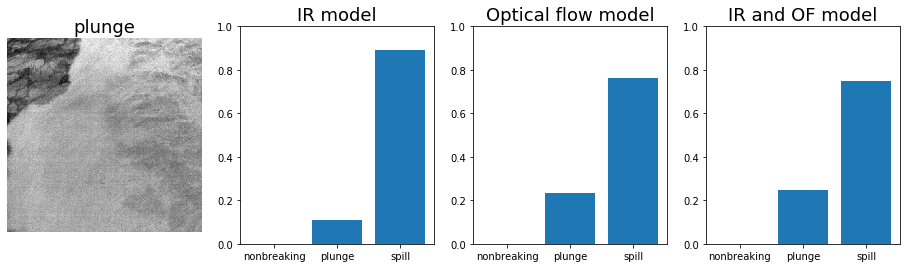

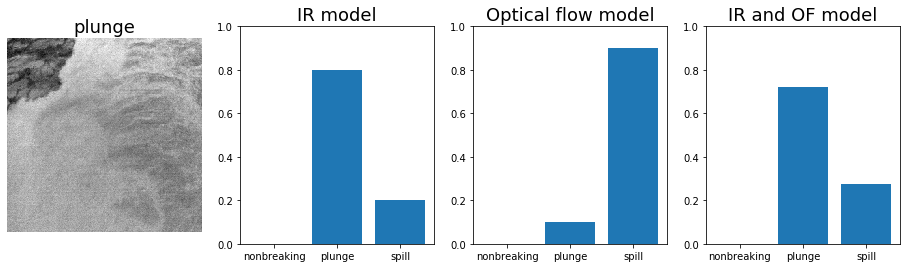

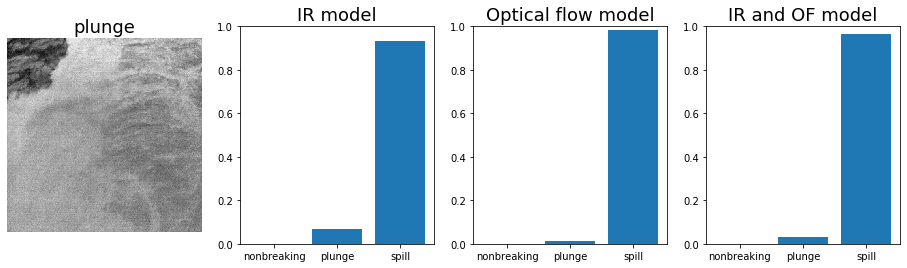

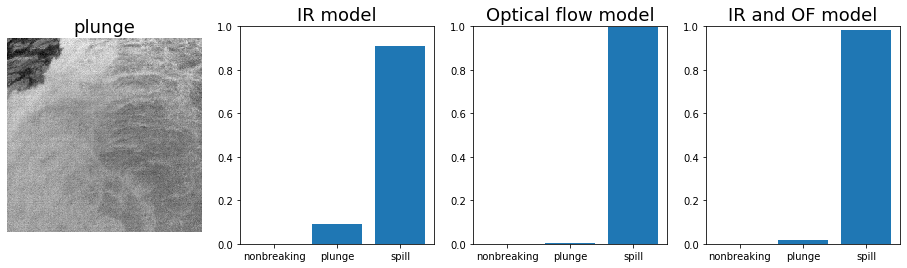

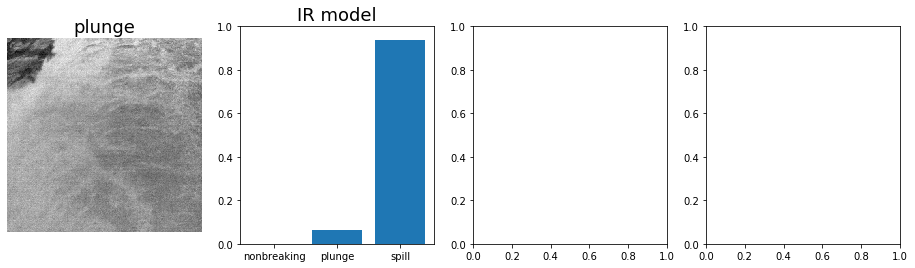

In [25]:
IRplunge, Floplunge, Lateplunge, IRplunge_brier, Floplunge_brier, Lateplunge_brier = get_wave_probs('plunge',
                                                        plungecat, 1)

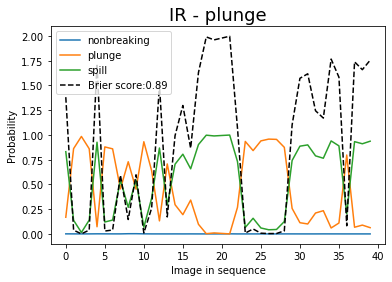

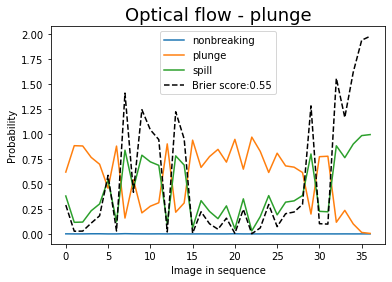

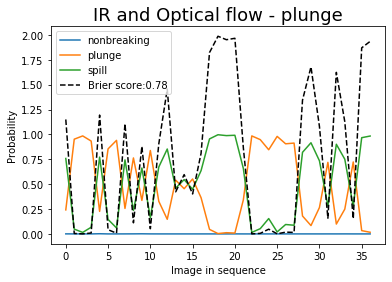

In [27]:
plot_wave_probs(IRplunge, IRplunge_brier, 'IR - plunge')
plot_wave_probs(Floplunge, Floplunge_brier, 'Optical flow - plunge')
plot_wave_probs(Lateplunge, Lateplunge_brier, 'IR and Optical flow - plunge')

In [30]:
spillcat = []
for i in spill_waves:
    spillcat = spillcat + i

In [34]:
IRspill, Flospill, Latespill, IRspill_brier, Flospill_brier, Latespill_brier = get_wave_probs('spill', 
                                                                  spillcat[:200], 
                                                                    2)

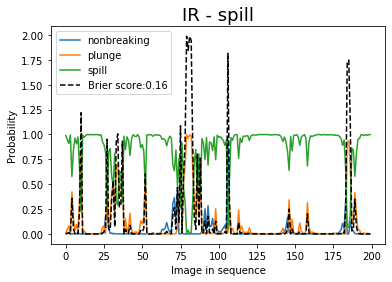

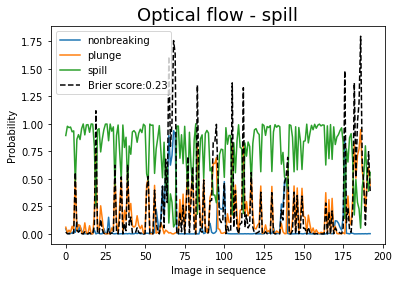

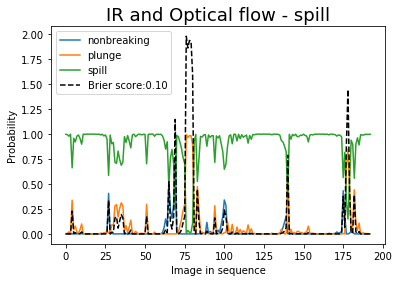

In [35]:
plot_wave_probs(IRspill, IRspill_brier, 'IR - spill')
plot_wave_probs(Flospill, Flospill_brier, 'Optical flow - spill')
plot_wave_probs(Latespill, Latespill_brier, 'IR and Optical flow - spill')

# Clustering

In [56]:
def get_feat_lab(feat_path, lab_path):
    feat = h5py.File(feat_path, 'r')
    lab = h5py.File(lab_path, 'r')
    
    feat = feat['dataset_1']
    lab = lab['dataset_1']
    return feat, lab

In [57]:
train_IR, train_IRlab = get_feat_lab('out/xception/IRfeatures.h5', 'out/xception/IRlabels.h5')
train_flo, train_flolab = get_feat_lab('out/xception/Flofeatures.h5','out/xception/Flolabels.h5')
train_IRflo, train_IRflolab = get_feat_lab('out/xception/IR2_flo_features.h5', 'out/xception/IR2_flo_labels.h5')
train_IRflo_late, train_IRflolab_late = get_feat_lab('out/xception/IR2flo_late_features.h5', 'out/xception/IR2flo_late_labels.h5')


In [58]:
def umap_cluster(features):
    cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                          n_components=2, random_state=1).fit_transform(features)
    return cluster

def umap_plot(cluster, label, title, save=None, **kwargs):
    fig = plt.figure(**kwargs)
    plt.scatter(cluster[:, 0], cluster[:, 1],
                c=label, cmap='RdYlGn', s=6, label=label)
    plt.title(title)
    if save:
        plt.savefig(save)
    plt.show()

def pl_sp(features, labels):
    new_data = np.array([])
    new_label = np.array([])
    for i, lab in enumerate(labels):
        if lab != 0:
            new_data = np.append(new_data, features[i])
            new_label = np.append(new_label, lab)
    new_data = np.reshape(new_data, (len(new_data)//np.shape(features)[1], np.shape(features)[1]))
    return new_data, new_label

In [42]:
IR_train_ps, IR_train_labps = pl_sp(train_IR, train_IRlab)
Flo_train_ps, Flo_train_labps = pl_sp(train_flo, train_flolab)
#IRFlo_train_ps, IRFlo_train_labps = pl_sp(train_IRflo_late, train_IRflolab_late)

In [43]:
IR_cluster_ps = umap_clust(IR_train_ps)
Flo_cluster_ps = umap_clust(Flo_train_ps)
#IRFlo_cluster_ps = umap_clust(IRFlo_train_ps)

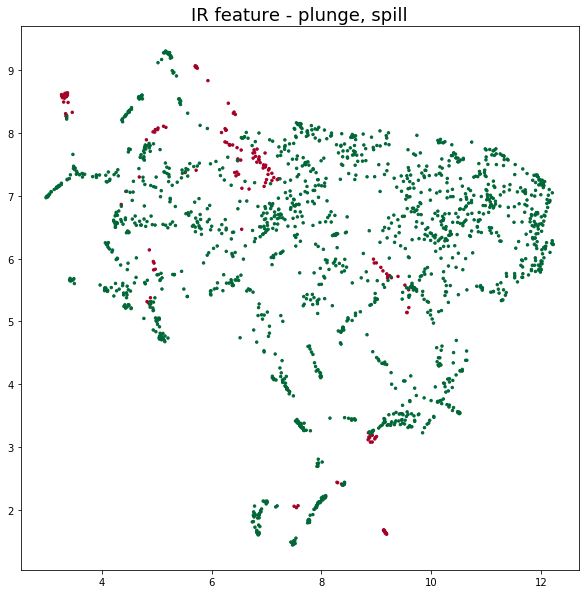

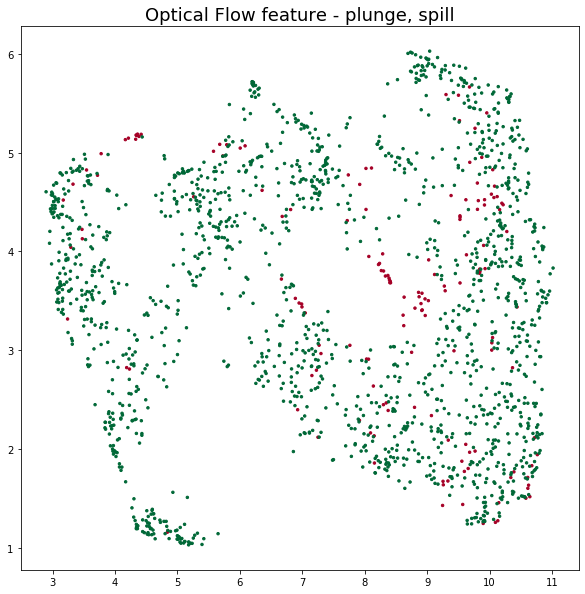

In [44]:
umap_plot(IR_cluster_ps, IR_train_labps, 'IR feature - plunge, spill',
         save='IR_cluster_PS', figsize=(10,10))
umap_plot(Flo_cluster_ps, Flo_train_labps, 'Optical Flow feature - plunge, spill',
         save='OF_cluster_PS', figsize=(10,10))
#umap_plot(IRFlo_cluster_ps, IRFlo_train_labps, 'IR and Optical Flow feature - plunge, spill',
        #save='IR_OF_cluster_PS', figsize=(10,10))

In [29]:
IR_cluster = umap_cluster(train_IR)
flo_cluster = umap_cluster(train_flo)
IRflo_cluster = umap_cluster(train_IRflo)
IRflo_late_cluster = umap_cluster(train_IRflo_late)

NameError: name 'umap_cluster' is not defined

In [ ]:
umap_plot(IR_cluster, train_IRlab, 'IR feature cluster')
#plt.savefig('IR_features_cluster.png')

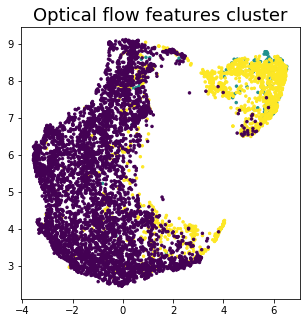

In [452]:
umap_plot(flo_cluster, train_flolab, 'Optical flow features cluster')
#plt.savefig('OpticalFlow_features_cluster.png')

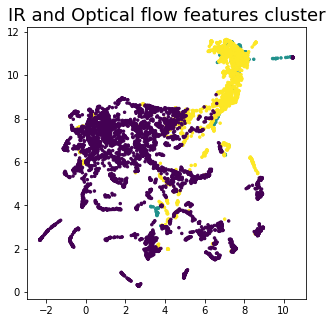

In [453]:
umap_plot(IRflo_cluster, train_IRflolab, 'IR and Optical flow features cluster')
#plt.savefig('IR_OpticalFlow_features_cluster.png')

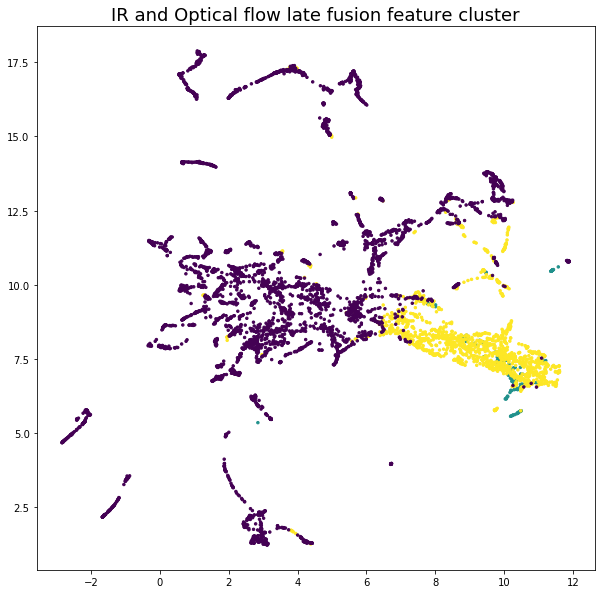

In [465]:
umap_plot(IRflo_late_cluster, train_IRflolab_late, 
          'IR and Optical flow late fusion feature cluster',
         save='IR_flo_late_features_cluster.png',
         figsize=(10,10))

# AUG

In [386]:
aug_train_IR = h5py.File('out/xception/IRfeatures_imaug.h5', 'r')
aug_train_IR = aug_train_IR['dataset_1']
aug_train_IRlab = h5py.File('out/xception/IRlabels_imaug.h5', 'r')
aug_train_IRlab = aug_train_IRlab['dataset_1']

aug_train_flo = h5py.File('out/xception/Flofeatures_imaug.h5', 'r')
aug_train_flo = aug_train_flo['dataset_1']
aug_train_flolab = h5py.File('out/xception/Flolabels_imaug.h5', 'r')
aug_train_flolab = aug_train_flolab['dataset_1']

augtrain_IRflo_late = h5py.File('out/xception/IR2flo_late_features_imaug.h5', 'r')
augtrain_IRflo_late = augtrain_IRflo_late['dataset_1']
augtrain_IRflolab_late = h5py.File('out/xception/IR2flo_late_labels_imaug.h5', 'r')
augtrain_IRflolab_late = augtrain_IRflolab_late['dataset_1']


In [222]:
augIR_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_IR)
augflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(aug_train_flo)
augIRflo_late_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, 
                               n_components=2, random_state=1).fit_transform(augtrain_IRflo_late)

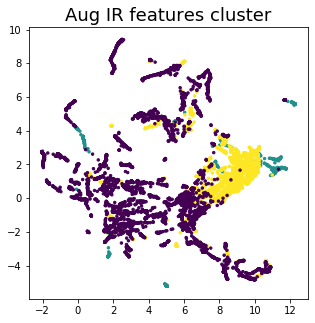

In [455]:
umap_plot(augIR_cluster, aug_train_IRlab, 'Aug IR features cluster')

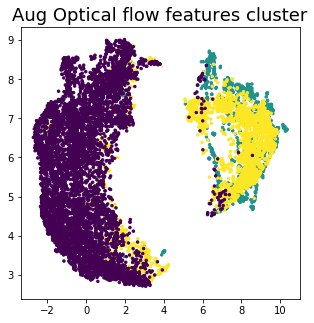

In [456]:
umap_plot(augflo_cluster, aug_train_flolab, 'Aug Optical flow features cluster')

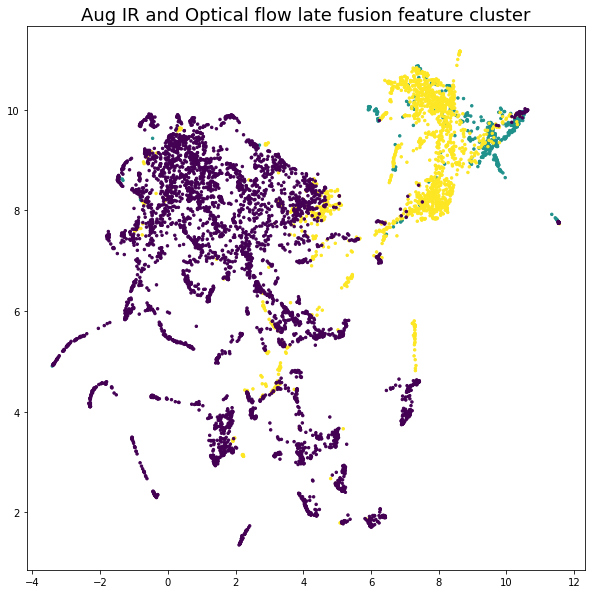

In [476]:
umap_plot(augIRflo_late_cluster, augtrain_IRflolab_late, 
        'Aug IR and Optical flow late fusion feature cluster',
         figsize=(10,10))

# TEST CLUSTERS

In [426]:
test_IR = h5py.File('out/xception/IRtestfeatures.h5', 'r')
test_IR = test_IR['dataset_1']
test_IRlab = h5py.File('out/xception/IRtestlabels.h5', 'r')
test_IRlab = test_IRlab['dataset_1']

test_flo = h5py.File('out/xception/Flotestfeatures.h5', 'r')
test_flo = test_flo['dataset_1']
test_flolab = h5py.File('out/xception/Flotestlabels.h5', 'r')
test_flolab = test_flolab['dataset_1']

test_IRflo = h5py.File('out/xception/IR2testfeatures.h5', 'r')
test_IRflo = test_IRflo['dataset_1']
test_IRflolab = h5py.File('out/xception/IR2testlabels.h5', 'r')
test_IRflolab = test_IRflolab['dataset_1']

test_IRflo_late = h5py.File('out/xception/IR2flo_late_testfeatures.h5', 'r')
test_IRflo_late = test_IRflo_late['dataset_1']
test_IRflolab_late = h5py.File('out/xception/IR2flo_late_testlabels.h5', 'r')
test_IRflolab_late = test_IRflolab_late['dataset_1']


testIR_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(test_IR)
testflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(test_flo)
testIRflo_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(test_IRflo)
testIRflo_late_cluster = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=1).fit_transform(test_IRflo_late)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

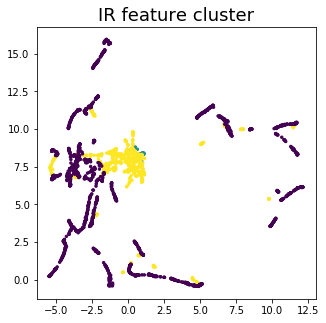

In [449]:
umap_plot(testIR_cluster, test_IRlab, 'IR feature cluster')

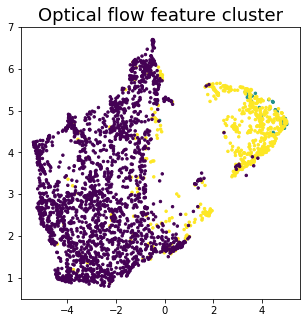

In [444]:
umap_plot(testflo_cluster, test_flolab, 'Optical flow feature cluster')

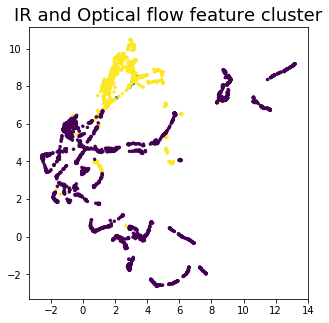

In [450]:
umap_plot(testIRflo_cluster, test_IRflolab, 'IR and Optical flow feature cluster')


In [ ]:
umap_plot(testIRflo_late_cluster, test_IRflolab_late, 'IR and Optical flow late fusion feature cluster')